### **Using TensorBoard with PyTorch**

#### **Before You Start**

To run this tutorial, you'll need to install PyTorch, TorchVision, Matplotlib, and TensorBoard.
With `conda`:

`conda install pytorch torchvision -c pytorch` `conda install matplotlib tensorboard`

With `pip`:

`pip install torch torchvision matplotlib tensorboard`

Once the dependencies are installed, restart this notebook in the Python environment where you installed them.


#### **Introduction**

In this notebook, we'll be training a variant of LeNet-5 against the Fashion-MNIST dataset. Fashion-MNIST is a set of image tiles depicting various garments, with fen class labels indicating the type of garment depicted

In [1]:
# PyTorch model and training necessities import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torch
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch Tensorboard support
from torch.utils.tensorboard import SummaryWriter

#### **Showing Images in TensorBoard**

Let's start by adding sample images from our dataset to TensorBoard:

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(), # 將 PIL 影像或 NumPy 陣列轉換為張量格式，並將像素值縮放至 [0, 1] 範圍內。
     transforms.Normalize((0.5, ), (0.5, ))])
     # 對資料進行標準化，將像素值調整到 [-1, 1] 範圍內，
     # 具體操作是對每個像素減去均值 0.5，然後再除以標準差 0.5。

# 資料集的準備
# Store separate training and validation splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
        train=True, # 下載訓練資料
        download=True, # 若本地無資料，則下載網路資料
        transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
        train=False,
        download=True,
        transform=transform)
training_loader = torch.utils.data.DataLoader(training_set,
        batch_size=4, # 每次輸入 4 張圖片
        shuffle=True, # 每次迭代前打亂資料，確保模型不會過度擬合
        num_workers=2) # 使用 2 個子進程加載資料
validation_loader = torch.utils.data.DataLoader(validation_set,
        batch_size=4,
        shuffle=False,
        num_workers=2)

# Class labels for FashionMNIST，10種類別標籤
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


`img = img.mean(dim=0)`，將圖片 img 沿著指定的維度進行均值運算。  
圖片通常表示為一個三維的張量（Tensor），其維度順序為 (C, H, W)，表示通道數（Channels）、高度（Height）和寬度（Width）。  
RGB 彩色圖像，C=3，對應紅、綠、藍三個通道。  
`mean(dim=0)`，指的是沿著 C 這個維度，也就是通道維度，對所有通道進行平均。這樣做的結果是將原本多通道的圖像轉換為單通道灰度圖像。  
$Gray(h,w)=\frac{Red(h,w)+Green(h,w)+Blue(h,w)}{3}$

In [3]:
# Helper function for inline images display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0) # 將圖片轉換為單通道。
    img = img / 2 + 0.5 # 反歸一化(unnormalize)回原始的值範圍，方便進行顯示。
    npimg = img.numpy() # 將張量轉換為 NumPy 陣列，以便於 matplotlib 進行顯示。
    if one_channel:
        plt.imshow(npimg, cmap='Greys') # 如果是單通道圖片，使用灰度圖顯示 (cmap='Greys')。
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

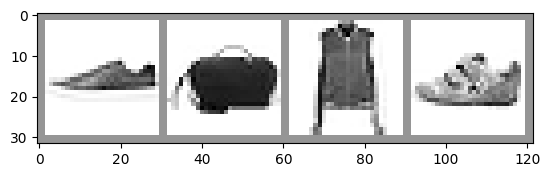

In [4]:
# 從 training_loader 中提取一批次的圖像
# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and display them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Above, we used TorchVision and Matplotlib to create a visual grid of a minibatch of our input data. Below, we use the `add_image()` call on `SummaryWriter` to log the image for consumption by TensorBoard, and we also call `flush()` to make sure it's written to disk right away.

* `SummaryWriter` 是 PyTorch 中用來與 TensorBoard 進行交互的類別。  
* `SummaryWriter('runs/fashion_mnist_experiment_1')` 創建了一個 `SummaryWriter` 實例，並將日誌數據寫入到 `runs/fashion_mnist_experiment_1` 目錄下。這個目錄用於存放 TensorBoard 的日誌文件，方便之後可視化模型的訓練過程。  
* 默認情況下，`log_dir` 參數的值是 `runs`，但這裡我們指定了路徑 `fashion_mnist_experiment_1`。  


* `add_image` 方法將一張圖像寫入到 TensorBoard 中。  
* `four_fashion_mnist_images` 是這次記錄的名稱標籤，你可以用它來標識這次寫入的圖像。  
* `img_grid` 是先前生成的包含 4 張 Fashion MNIST 圖像的網格。  

In [5]:
# Default log_dir argument is "run" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write the image data to TensorBoard log dir
writer.add_image('four_fashion_mnist_images', img_grid)
writer.flush() # 強制將所有緩存的內容寫入到磁盤，確保數據不會因緩存而丟失。

# To view, start TensorBoard on the command line with:
# tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

If you start TensorBoard at the command line and open it in a new browser tab (usually at localhost:6006), you should see the image grid under the IMAGES tab.

### **Graphing Scalars to Visualize Training**

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we'll run a training loop, track some metrics, and save the data for TensorBoard's consumption.

Let's define a model to categorize our image tiles, and an optimizer and loss function for training:

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss() # 使用交叉熵損失函數，進行多分類問題的分類。
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 使用隨機梯度下降（SGD）作為優化器

`view` 是 PyTorch 中的函數，它用來改變張量的形狀而不改變其數據本身。  
* -1: 這是自動推導的維度。PyTorch 會根據張量的總元素數量和其他給定的維度，計算出 -1 應該是多少，以保證形狀的正確性。在這裡，-1 將會被計算為 B，即批次大小。
* 16 * 4 * 4: 這裡指定了每個樣本的扁平化特徵向量的長度，16 是通道數，4 和 4 是特徵圖的高度和寬度。乘積 16 * 4 * 4 表示每個樣本在展平成一維向量後的總長度。

Now let's train a single epoch, and evaluate the training vs. validation set losses every 1000 batches:

In [7]:
print(len(validation_loader)) # 檢查驗證資料集被分成了多少個 mini-batches。
# 這個迴圈表示模型將會在整個訓練資料集上訓練 1 次（即一個 epoch）。
for epoch in range(1): # loop over the dataset multiple times
    running_loss = 0.0

    # 對訓練資料集的每一個 mini-batch 進行操作
    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad() # 清除累積的梯度（在 PyTorch 中，梯度會累積，這一步確保每次更新都是針對當前 mini-batch 的）。
        outputs = net(inputs)
        loss = criterion(outputs, labels) # 使用損失函數 criterion 計算預測輸出與真實標籤之間的損失。
        loss.backward() # 使用反向傳播計算梯度。
        optimizer.step() # 更新模型參數。

        running_loss += loss.item()
        if i % 1000 == 999: # Every 1000 mini-batches...
            print('Batch({}'.format(i + 1))
            # check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't need to track gradients for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradient tracking back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss avgeraged per batch
            writer.add_scalars('Training vs. Validation Loss',
                    {'Training' : avg_loss, 'Validation' : avg_vloss},
                    epoch * len(training_loader) + i)
            running_loss = 0.0

print('Finished Training')

writer.flush()

2500
Batch(1000
Batch(2000
Batch(3000
Batch(4000
Batch(5000
Batch(6000
Batch(7000
Batch(8000
Batch(9000
Batch(10000
Batch(11000
Batch(12000
Batch(13000
Batch(14000
Batch(15000
Finished Training


Switch to your open TensorBoard and have a look at the SCALARS tab.

#### **Visualizing Your Model**  
TensorBoard can also be used to examine the data flow within your model. To do this, call the `add_graph()` method with a model and sample input. When 
you open

In [8]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph
writer.add_graph(net, images)
writer.flush()

When you switch over to TensorBoard, you should see a GRAPHS tab. Double-click the 'NET" node to see the layers and data flow within your model.

#### **Visualizing Your Dataset with Embeddings**  
The 28-by-28 image tiles we're using can be modeled as 784-dimensional vectors (28 * 28 = 784). It can be instructive to project this to a lower-dimensional
representation. The `add_embedding()` method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart. The `add_embedding()` method does this automatically by projecting to the three dimensions with highest variance.
Below, we'll take a sample of our data, and generate such an embedding:

In [9]:
# Select a random subset of images and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# Get the class labels for the random subset
class_labels = [classes[label] for label in labels]

#log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
        metadata=class_labels,
        label_img=images.unsqueeze(1))

writer.flush() # Flush the writer to ensure all data is written to disk



Now if you switch to TensorBoard and select the PROJECTOR tab, you should see a 3D representation of the projection. You can rotate and zoom the model.  
Examine it at large and small scales, and see whether you can spot patterns in the projected data and the clustering of labels.

**Note:** For better visibility, it's recommended to:  
* Select "label" from the "Color by" drop-down on the left
* Toggle the Night Mode icon along the top to place the light-colored images on a dark background.

#### **Other Resources**
For more information, have a look at:
* PyTorch documentation on `torch.utils.tensorboard.SummaryWriter` on PyTorch.org